In [1]:
# === Environment Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, Markdown

# --- Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8), 'figure.dpi': 150})
np.set_printoptions(suppress=True, linewidth=120, precision=4)

# --- Utility Functions ---
def note(msg): display(Markdown(f"<div class='alert alert-info'>📝 {msg}</div>"))
def sec(title): print(f'\n{80*"="}\n| {title.upper()} |\n{80*"="}')

note("Environment initialized for Time Series Analysis.")

<div class='alert alert-info'>📝 Environment initialized for Time Series Analysis.</div>

# Chapter 8.1: Introduction to Time Series Analysis

---

### Table of Contents

1.  [**Introduction: The Nature of Time Series Data**](#intro)
2.  [**Stochastic Processes and Stationarity**](#stationarity)
    - [Weak vs. Strict Stationarity](#weak-strict)
3.  [**Characterizing Serial Correlation: ACF and PACF**](#acf-pacf)
    - [Code Lab: Visualizing ACF and PACF for Sample Processes](#code-acf)
4.  [**The Lag Operator and Characteristic Equations**](#lag-operator)
5.  [**Exercises**](#exercises)
6.  [**Summary and Key Takeaways**](#summary)

<a id='intro'></a>
## 1. Introduction: The Nature of Time Series Data

**Time series data** consists of a sequence of observations on a variable taken at successive, equally spaced points in time. Examples include the quarterly GDP of a country, the daily price of a stock, or the monthly unemployment rate. Unlike cross-sectional data, the ordering of time series data is crucial because the past often contains valuable information about the future.

The central goal of time series analysis is to understand, model, and forecast this temporal structure. While the pioneering work of statisticians **George Box** and **Gwilym Jenkins** in their 1970 book *Time Series Analysis: Forecasting and Control* popularized a comprehensive methodology, the foundations were laid much earlier. **Udny Yule** (1927) first introduced autoregressive (AR) models to study sunspot cycles, and **Eugen Slutsky** (1937) showed that moving average (MA) processes could generate cyclical behavior similar to economic data, demonstrating the famous Slutsky-Yule effect where random shocks can create illusory patterns.

A key feature of time series data is **serial correlation** (or autocorrelation), where observations are correlated with their own past values. This violates the standard OLS assumption of independent observations and requires a specialized set of statistical tools. This module will build up these tools, starting from the foundational concepts of stationarity and moving towards sophisticated models for forecasting and analyzing economic and financial data.

<a id='stationarity'></a>
## 2. Stochastic Processes and Stationarity

A time series can be thought of as a single **realization** of a **stochastic process** (or *data generating process*, DGP). A stochastic process is a sequence of random variables indexed by time. 

Think of it this way: there is an underlying process that has a certain mean, variance, and correlational structure. This process could generate an infinite number of possible time series paths. The actual data we observe—the GDP of Canada from 1960 to today—is just one of those paths. The diagram below illustrates this: it shows five different possible paths (`realizations`) generated from the *same* underlying stationary process. They all share the same statistical properties (e.g., they revert to the same mean), but their specific values differ due to random shocks.

![Multiple Realizations of a Stochastic Process](../images/08-Time-Series/stochastic_process_realizations.png)

For us to model a time series statistically, the properties of this underlying process must be stable, or **stationary**, over time.

<a id='weak-strict'></a>
### Weak vs. Strict Stationarity

**Strict Stationarity:** A process is strictly stationary if the joint probability distribution of any set of $k$ observations is the same as the joint distribution of any other set of $k$ observations shifted in time. This is a very strong condition and is rarely met in practice.

**Covariance (Weak) Stationarity:** A process is weakly stationary if its first two moments are time-invariant. This is the condition required for most time series modeling. It requires three properties to hold:
1.  **Constant Mean:** $E[y_t] = \mu$ for all $t$.
2.  **Constant Variance:** $Var(y_t) = \sigma^2$ for all $t$.
3.  **Constant Covariance:** $Cov(y_t, y_{t-k}) = \gamma_k$ depends only on the lag $k$, not on time $t$.

Processes with trends, seasonality, or changing volatility are non-stationary. A primary goal of time series analysis is often to transform non-stationary data (e.g., by differencing) into a stationary form that can be modeled.


| VISUALIZING STATIONARY VS. NON-STATIONARY PROCESSES |


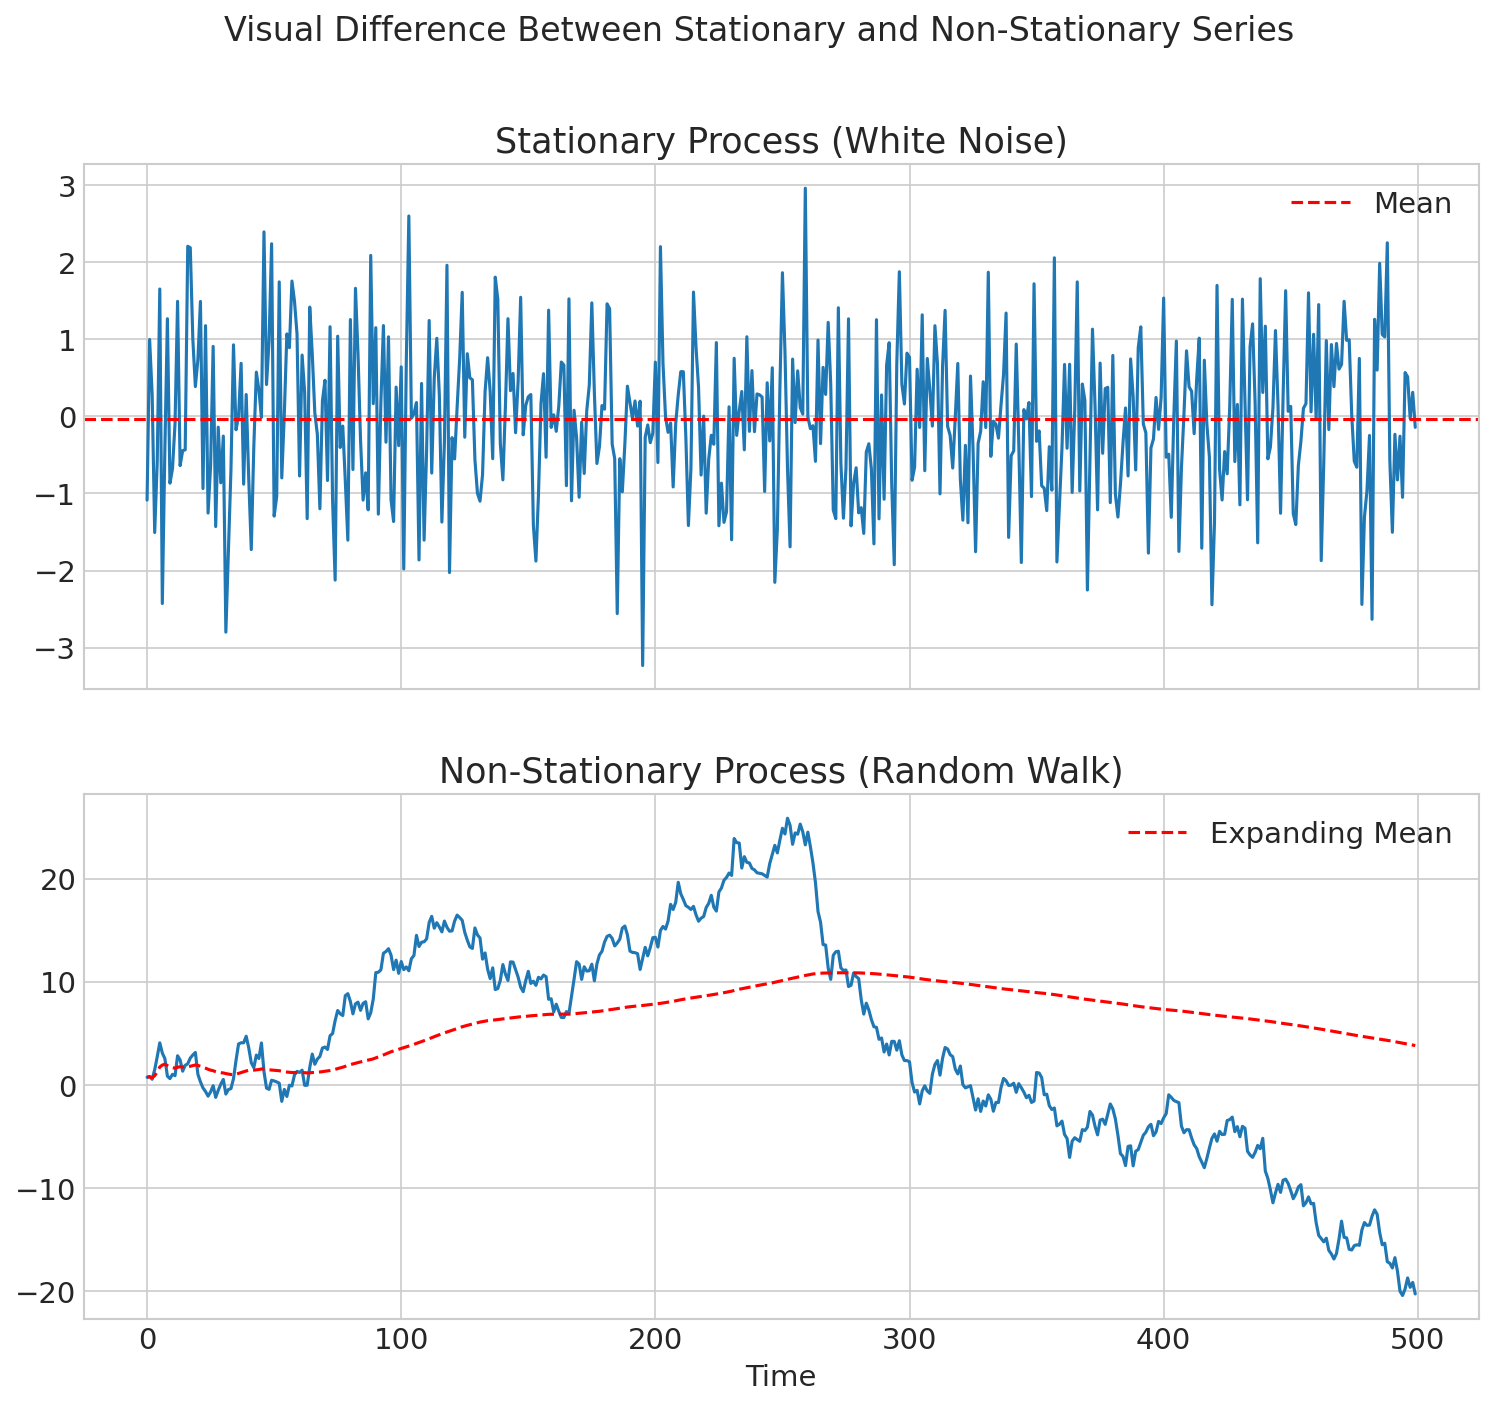

<div class='alert alert-info'>📝 Notice how the stationary series constantly reverts to its mean, while the non-stationary series wanders without a fixed anchor. Its variance clearly increases over time.</div>

In [2]:
sec("Visualizing Stationary vs. Non-Stationary Processes")

np.random.seed(123)
steps = 500

# 1. Stationary Process (White Noise)
stationary_series = np.random.normal(size=steps)

# 2. Non-Stationary Process (Random Walk)
# A random walk is y_t = y_{t-1} + e_t. Its mean is constant (0), but its variance increases with time.
non_stationary_series = np.cumsum(np.random.normal(size=steps))

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(stationary_series)
ax1.set_title('Stationary Process (White Noise)')
ax1.axhline(stationary_series.mean(), color='r', linestyle='--', label='Mean')
ax1.legend()

ax2.plot(non_stationary_series)
ax2.set_title('Non-Stationary Process (Random Walk)')
# Note: The mean of a random walk is not constant, but we plot the sample mean for comparison
ax2.plot(pd.Series(non_stationary_series).expanding().mean(), color='r', linestyle='--', label='Expanding Mean')
ax2.legend()

plt.xlabel('Time')
plt.suptitle('Visual Difference Between Stationary and Non-Stationary Series', fontsize=16)
plt.show()

note('Notice how the stationary series constantly reverts to its mean, while the non-stationary series wanders without a fixed anchor. Its variance clearly increases over time.')

#### Unpacking the Code: `np.cumsum` and the Random Walk

The code above generates a random walk by using `np.cumsum()` on a series of random normal shocks. This is a direct and efficient way to implement the equation $ y_t = y_{t-1} + \epsilon_t $. If we expand this recursively, we see that:
$$ y_t = y_0 + \sum_{i=1}^{t} \epsilon_i $$
This shows that the value of the series at any point $t$ is the **cumulative sum** of all past shocks, plus a starting value. This is precisely what `np.cumsum()` calculates. This cumulative memory is why shocks to a random walk are permanent and why the variance grows with time.

The plot for the non-stationary series also includes an **expanding mean**, calculated with `pd.Series(non_stationary_series).expanding().mean()`. This computes the mean of the series using an ever-larger window of data: the mean at time `t` is the average of all observations from `0` to `t`. For a stationary series, this expanding mean would quickly converge to the true, constant mean of the process. However, for the random walk, the plot clearly shows that this mean is not constant; it drifts along with the series itself. This provides strong visual evidence that the first condition for stationarity—a constant mean—is violated.

### Wold's Decomposition Theorem

A foundational result in time series analysis is **Wold's Decomposition Theorem** (Herman Wold, 1938). It provides the theoretical justification for the entire ARMA modeling framework. The theorem states that any covariance-stationary time series, $y_t$, can be uniquely represented as the sum of two components:
1.  A **linearly deterministic component**, $d_t$, which is perfectly predictable using past observations (e.g., a constant mean or a time trend).
2.  A **linearly indeterministic (stochastic) component**, which is a linear combination of past and present white noise error terms.

$$ y_t = d_t + \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j} \quad \text{where} \; \psi_0=1 \; \text{and} \; \sum_{j=0}^{\infty} \psi_j^2 < \infty $$

where $\epsilon_t$ is a white noise process (uncorrelated random shocks with mean zero) and the $\psi_j$ are the coefficients of an infinite moving average (MA($\infty$)) process.

**Why is this important?** It is a profound result. It tells us that even highly complex stationary processes can be broken down into a predictable part and a stochastic part that is fundamentally driven by a simple series of random shocks. The ARMA models we study are, in essence, finite-parameter approximations of this infinite-order moving average representation guaranteed by Wold's theorem. It gives us confidence that by identifying the right ARMA(p, q) model, we can capture the essential dynamics of any stationary time series.

<a id='acf-pacf'></a>
## 3. Characterizing Serial Correlation: ACF and PACF

To identify the structure of a stationary time series (i.e., to find the right p and q for our ARMA model), we use two key diagnostic tools:

1.  **Autocorrelation Function (ACF):** The ACF at lag $k$, denoted $\rho_k$, is the correlation between the series and its own past values, separated by $k$ time steps.
    $$ \rho_k = \frac{Cov(y_t, y_{t-k})}{Var(y_t)} = \frac{\gamma_k}{\gamma_0} $$
    The ACF measures the *total* correlation (direct and indirect) between $y_t$ and $y_{t-k}$. For example, the correlation at lag 2 is partly due to the direct effect of $y_{t-2}$ on $y_t$ and partly due to the indirect effect through $y_{t-1}$ (since $y_{t-2}$ affects $y_{t-1}$, which in turn affects $y_t$).

2.  **Partial Autocorrelation Function (PACF):** The PACF at lag $k$ is the correlation between $y_t$ and $y_{t-k}$ *after* controlling for (or "partialing out") the effects of all the intermediate lags ($y_{t-1}, y_{t-2}, ..., y_{t-k+1}$). It measures the *direct* relationship between $y_t$ and $y_{t-k}$.

The patterns of decay in the ACF and PACF plots, known as correlograms, are the primary way we identify the appropriate AR, MA, or ARMA model for a time series.

**Interpreting Correlograms**: The plots of the ACF and PACF are called **correlograms**. The `statsmodels` plots also include a shaded cone. This is the confidence interval (typically 95%). Autocorrelations that fall outside this cone are considered statistically significant (i.e., unlikely to be zero due to random chance).

<a id='code-acf'></a>
### Correlogram Patterns for Model Identification

| Process | ACF Pattern | PACF Pattern |
| :--- | :--- | :--- |
| **AR(p)** | Decays exponentially or shows a damped sine wave pattern | Cuts off sharply after **lag p** |
| **MA(q)** | Cuts off sharply after **lag q** | Decays exponentially |
| **ARMA(p,q)**| Decays exponentially after lag q | Decays exponentially after lag p |


| ACF AND PACF OF SAMPLE PROCESSES |


<div class='alert alert-info'>📝 For an AR(1) process, the ACF decays exponentially, while the PACF cuts off sharply after lag 1.</div>

<div class='alert alert-info'>📝 For an MA(1) process, the ACF cuts off sharply after lag 1, while the PACF decays exponentially.</div>

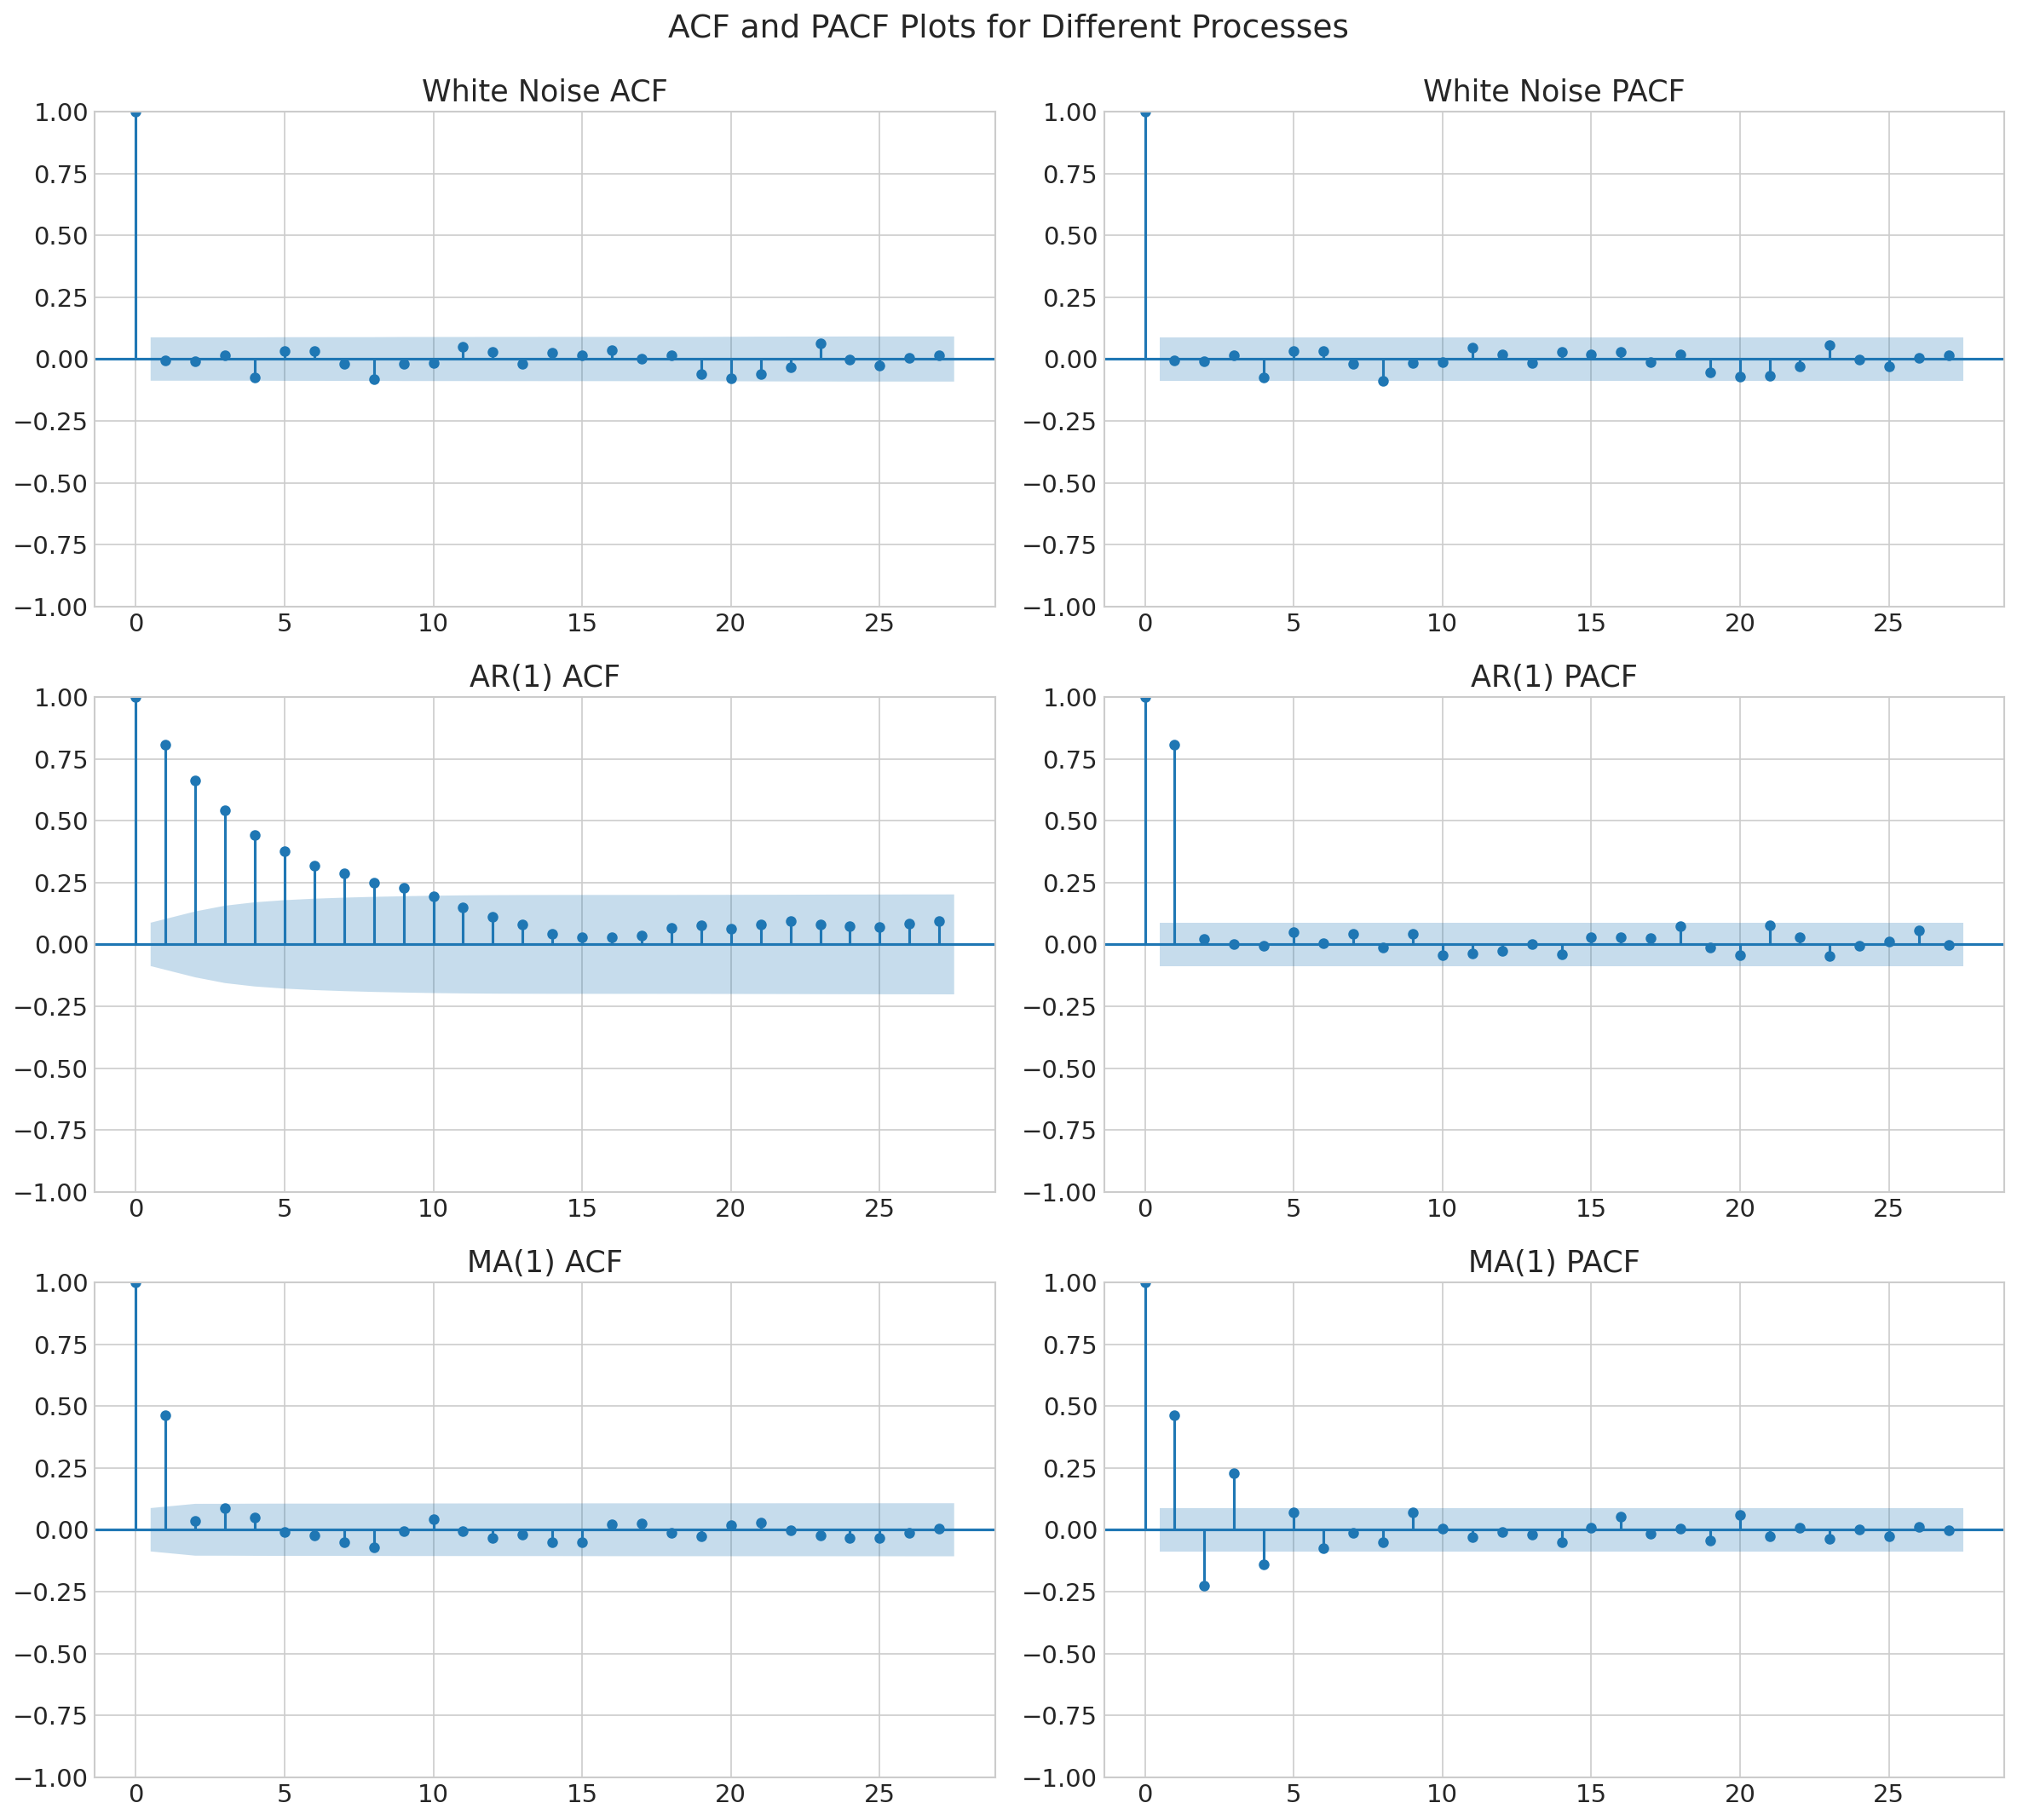

In [3]:
sec("ACF and PACF of Sample Processes")

# Set a random seed for reproducibility
np.random.seed(42)

# 1. White Noise: A process with no memory.
# Economic intuition: Asset returns under the Efficient Market Hypothesis are often modeled as white noise, 
# implying that past returns have no predictive power over future returns.
wn = np.random.normal(size=500)

# 2. AR(1) Process: A process with persistent memory.
# The term `0.8 * ar1[t-1]` means that 80% of the value from the previous period persists into the current period.
# Economic intuition: GDP growth is often modeled as an AR process. A shock (like a policy change or oil price spike)
# doesn't just affect growth in one quarter; its effects persist and decay over several subsequent quarters.
ar1 = np.zeros(500)
for t in range(1, 500):
    ar1[t] = 0.8 * ar1[t-1] + np.random.normal()

# 3. MA(1) Process: A process with a one-period memory of shocks.
# The value at time t depends on the current shock (errors[t]) and the previous period's shock (errors[t-1]).
# Economic intuition: Imagine a surprise announcement causes a one-time spike in a stock price. An MA(1) model
# suggests this shock affects the price in the period it occurs and the next period, but has no influence after that.
errors = np.random.normal(size=500)
ma1 = np.zeros(500)
for t in range(1, 500):
    ma1[t] = errors[t] + 0.7 * errors[t-1]

# --- Plotting ---
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
fig.suptitle('ACF and PACF Plots for Different Processes', fontsize=18, y=0.95)

# White Noise Plots
plot_acf(wn, ax=axes[0, 0], title='White Noise ACF')
plot_pacf(wn, ax=axes[0, 1], title='White Noise PACF')

# AR(1) Plots
plot_acf(ar1, ax=axes[1, 0], title='AR(1) ACF')
plot_pacf(ar1, ax=axes[1, 1], title='AR(1) PACF')
note("For an AR(1) process, the ACF decays exponentially, while the PACF cuts off sharply after lag 1.")

# MA(1) Plots
plot_acf(ma1, ax=axes[2, 0], title='MA(1) ACF')
plot_pacf(ma1, ax=axes[2, 1], title='MA(1) PACF')
note("For an MA(1) process, the ACF cuts off sharply after lag 1, while the PACF decays exponentially.")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<a id='lag-operator'></a>
## 4. The Lag Operator and Characteristic Equations

To work with time series models more formally, it is convenient to use the **lag operator**, $L$, which shifts the time index of a variable back by one period: $L y_t = y_{t-1}$.

Using the lag operator, we can write an AR(p) process, $y_t = \phi_1 y_{t-1} + ... + \phi_p y_{t-p} + \epsilon_t$, more compactly:
$$ (1 - \phi_1 L - \phi_2 L^2 - ... - \phi_p L^p) y_t = \epsilon_t $$
$$ \Phi(L) y_t = \epsilon_t $$
Where $\Phi(L)$ is a polynomial in the lag operator. The equation $\Phi(z) = 0$ is called the **characteristic equation** of the process. The roots of this characteristic equation determine the stability and stationarity of the process. For an AR process to be stationary, all roots of its characteristic equation must lie *outside* the unit circle.

<a id='exercises'></a>
## 5. Exercises

1.  **Non-Stationarity:** Give two examples of economic time series that are likely to be non-stationary and explain why.
2.  **ACF/PACF Interpretation:** You observe a time series whose ACF cuts off sharply after lag 2, while its PACF decays exponentially. What kind of process is this likely to be?
3.  **The Lag Operator:** Use the lag operator to write out the compact form of an MA(q) process, $y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$.
4.  **Invertibility:** The condition for an MA process to be 'invertible' (meaning it can be represented as an infinite AR process) is that the roots of its characteristic equation lie outside the unit circle. Is the process $y_t = \epsilon_t - 1.2 \epsilon_{t-1}$ invertible? Why or why not?
5.  **Code Challenge:** A random walk with drift is defined as $y_t = c + y_{t-1} + \epsilon_t$. This is a non-stationary process. Write a short Python script to simulate 200 steps of this process with $c=0.5$ and $\epsilon_t \sim N(0, 1)$. Plot the resulting series. What do you observe?

<a id='summary'></a>
## 6. Summary and Key Takeaways

This chapter introduced the foundational concepts needed to analyze time series data.

**Key Concepts**:
- **Time Series Data**: Is a sequence of observations ordered in time. Its defining feature is serial correlation.
- **Stationarity**: A key assumption for many time series models. A (weakly) stationary process has a constant mean, constant variance, and a covariance that depends only on the lag, not on time.
- **ACF and PACF**: The Autocorrelation and Partial Autocorrelation Functions are the primary tools for diagnosing the structure of a stationary time series. Their patterns of decay or cutoff tell us which model (AR, MA, ARMA) is most appropriate.
- **Lag Operator**: A convenient notation for writing and manipulating time series models. The roots of a model's characteristic equation determine its stationarity and invertibility.

### Solutions to Exercises

---

**1. Non-Stationarity:**
   a. **Real GDP:** Most countries' GDP exhibits a clear upward trend over time due to population growth, capital accumulation, and technological progress. A process with a trend does not have a constant mean, so it is non-stationary.
   b. **Stock Prices:** The variance of stock prices (and returns) is often not constant. It exhibits periods of high volatility (like during a financial crisis) and periods of low volatility. This property of time-varying variance is called heteroskedasticity, and it violates the constant variance condition for stationarity.

---

**2. ACF/PACF Interpretation:**
This pattern—a sharp cutoff in the ACF and an exponential decay in the PACF—is the characteristic signature of a **Moving Average (MA)** process. Since the ACF cuts off after lag 2, it is an **MA(2)** process.

---

**3. The Lag Operator for MA(q):**
The MA(q) process is $y_t = (1 + \theta_1 L + \theta_2 L^2 + ... + \theta_q L^q) \epsilon_t$. We can write this as $y_t = \Theta(L) \epsilon_t$.

---

**4. Invertibility:**
The model is $y_t = (1 - 1.2L) \epsilon_t$. The characteristic equation is $1 - 1.2z = 0$. The root is $z = 1/1.2 \approx 0.833$. Since the absolute value of the root is less than 1, it lies *inside* the unit circle. Therefore, the process is **not invertible**.